In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import ee
import geemap
import rasterio

In [2]:
ee.Authenticate

<function ee.Authenticate(authorization_code: str | None = None, quiet: bool | None = None, code_verifier: str | None = None, auth_mode: str | None = None, scopes: collections.abc.Sequence[str] | None = None, force: bool = False) -> bool | None>

In [3]:
ee.Initialize(project = 'ee-subhalekhapandi')

In [4]:
Madurai = ee.Geometry.Rectangle([78.05, 9.80, 78.25, 10.05])
Madurai_Area = Madurai.area(maxError = 1)

In [5]:
print("Madurai area in square meters:", Madurai_Area.getInfo())

Madurai area in square meters: 608964956.4264185


In [6]:
sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

In [7]:
pre_monsoon_2020 = sentinel2.filterBounds(Madurai) \
    .filterDate('2020-02-01', '2020-04-30') \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 20)
print("Number of pre-monsoon images:", pre_monsoon_2020.size().getInfo())


Number of pre-monsoon images: 15


In [8]:
post_monsoon_2020 = (
    sentinel2
    .filterBounds(Madurai)
    .filterDate('2020-10-01', '2020-12-31')
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 20)
)
print("Number of post-monsoon images:", post_monsoon_2020.size().getInfo())


Number of post-monsoon images: 3


In [9]:
pre_monsoon_composite = pre_monsoon_2020.median()
post_monsoon_composite = post_monsoon_2020.median()


In [10]:
ndvi_pre_monsoon = pre_monsoon_composite.normalizedDifference(['B8', 'B4'])
ndvi_post_monsoon = post_monsoon_composite.normalizedDifference(['B8', 'B4'])
# NDVI = (NIR - Red) / (NIR + Red)

In [11]:
Map = geemap.Map(center=[9.95, 78.15], zoom=10)
ndvi_vis = {
    'min': 0,
    'max': 1,
    'palette': ['brown', 'yellow', 'green']
} #scientifically conventional.
Map.addLayer(ndvi_pre_monsoon, ndvi_vis, 'NDVI Pre-Monsoon 2016')
Map.addLayer(ndvi_post_monsoon, ndvi_vis, 'NDVI Post-Monsoon 2016')
Map.addLayer(Madurai, {'color': 'blue'}, 'Madurai Boundary')
#Map.add_basemap('SATELLITE')
Map

Map(center=[9.95, 78.15], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [12]:
ndvi_difference = ndvi_post_monsoon.subtract(ndvi_pre_monsoon)


In [13]:
Map = geemap.Map(center=[9.95, 78.15], zoom=10)
diff_vis = {
    'min': -0.5,
    'max': 0.5,
    'palette': ['red', 'white', 'green']
}
Map.addLayer(ndvi_difference, diff_vis, 'NDVI Difference (Post - Pre) 2016')
Map.addLayer(Madurai, {'color': 'blue'}, 'Madurai Boundary')
Map.addLayerControl()
Map

Map(center=[9.95, 78.15], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [14]:
geemap.ee_export_image(
    ndvi_difference,
    filename="ndvi_difference_2020.tif",
    scale=30,
    region=Madurai,
    file_per_band=False
)


Generating URL ...
Please wait ...
Data downloaded to C:\Users\Admin\EO\ndvi_difference_2020.tif


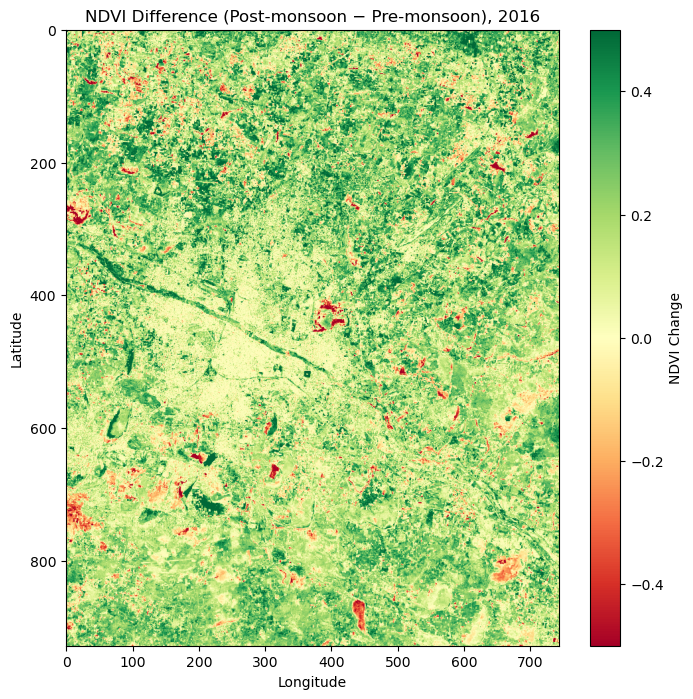

In [15]:
with rasterio.open("ndvi_difference_2020.tif") as src:
    ndvi = src.read(1)

plt.figure(figsize=(8, 8))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-0.5, vmax=0.5)
plt.colorbar(label='NDVI Change')
plt.title('NDVI Difference (Post-monsoon − Pre-monsoon), 2016')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

NDVI values were visualized using a red–yellow–green color scale, where red represents low or negative NDVI values and green indicates high vegetation density. The color scale was fixed between −0.5 and +0.5 to enhance contrast over vegetated land and ensure comparability between seasonal maps.